<a href="https://colab.research.google.com/github/DavidCastro88/AssemblyMethodsForTimeSeriesForecasting/blob/main/AssemblyMethods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Time Series Forecasting with Assembly Methods***

In this paper, we will explore how to apply ensemble techniques, specifically bagging, boosting, and stacking, in time series prediction, models different from those conventionally used. We will use historical data of the daily closing price of Bancolombia shares to demonstrate how these methods can improve the accuracy of the models. We will compare the results obtained by each technique and discuss their advantages in financial analysis.

In [ ]:
!pip install yfinance

In [1]:
#Libraries
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# Metrics
from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

#XGBoost (Boosting)
from xgboost import XGBRegressor

#Random Forest (Bagging)
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

#Stacking
from sklearn.ensemble import StackingRegressor,GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

#Data source
import yfinance as yf

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [68]:
ticker = 'CIB'
data = yf.download(ticker, start='2023-01-01', end='2024-10-11')
data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-01-03,28.540001,28.540001,27.129999,27.160000,22.139643,236600
2023-01-04,27.410000,27.959999,26.950001,27.900000,22.742859,426800
2023-01-05,27.920000,28.040001,27.620001,27.959999,22.791763,430100
2023-01-06,28.120001,28.559999,28.020000,28.480000,23.215649,230500
2023-01-09,29.110001,29.120001,28.620001,28.790001,23.468348,154700


In [69]:
#We select the feature of interest
data = data[['Adj Close']]

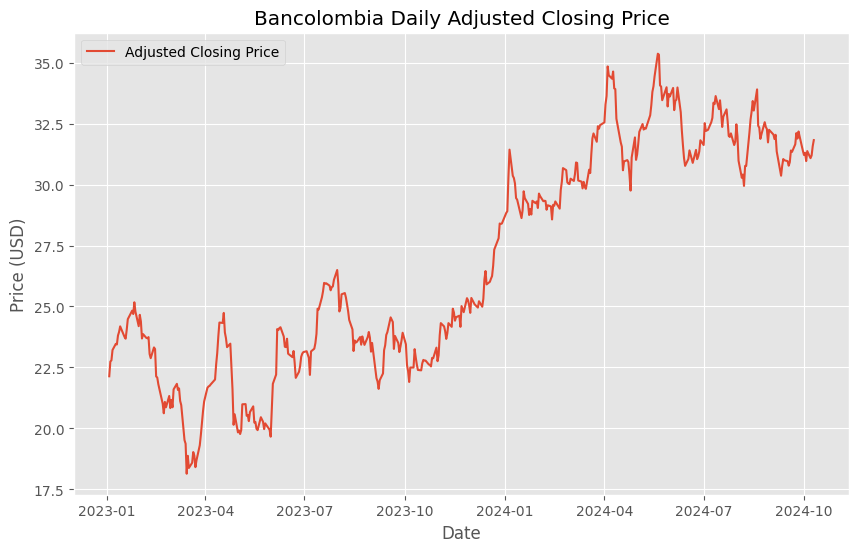

In [70]:
#Graph
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['Adj Close'], label='Adjusted Closing Price')
plt.title('Bancolombia Daily Adjusted Closing Price')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid(True)
plt.legend()
plt.show()

## **Feature Engineering for Time-Series Data**

In [71]:
# Creating lag features for time-series data
def create_lag_features(data, lag_steps=3):
  for i in range(1, lag_steps + 1):
    data[f'lag_{i}'] = data['Adj Close'].shift(i)
  return data

In [72]:
data = create_lag_features(data,7)

In [73]:
data

,Adj Close,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
Date,,,,,,,,
2023-01-03,22.139643,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-04,22.742859,22.139643,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-05,22.791763,22.742859,22.139643,NaN,NaN,NaN,NaN,NaN
2023-01-06,23.215649,22.791763,22.742859,22.139643,NaN,NaN,NaN,NaN
2023-01-09,23.468348,23.215649,22.791763,22.742859,22.139643,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2024-10-04,31.370001,30.959999,31.299999,31.209999,31.379999,31.969999,32.174000,31.881687
2024-10-07,31.080000,31.370001,30.959999,31.299999,31.209999,31.379999,31.969999,32.174000
2024-10-08,31.190001,31.080000,31.370001,30.959999,31.299999,31.209999,31.379999,31.969999


In [74]:
#Drop NA values
data.dropna(inplace=True)

In [75]:
data.head()

,Adj Close,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
Date,,,,,,,,
2023-01-12,23.957439,23.810711,23.443892,23.468348,23.215649,22.791763,22.742859,22.139643
2023-01-13,24.185684,23.957439,23.810711,23.443892,23.468348,23.215649,22.791763,22.742859
2023-01-17,23.753651,24.185684,23.957439,23.810711,23.443892,23.468348,23.215649,22.791763
2023-01-18,23.680286,23.753651,24.185684,23.957439,23.810711,23.443892,23.468348,23.215649
2023-01-19,24.038956,23.680286,23.753651,24.185684,23.957439,23.810711,23.443892,23.468348


## Train-Test Split

In [76]:
# Splitting time-series data into training and testing sets
train_size = int(len(data) * 0.85)
train_data, test_data = data[:train_size], data[train_size:]

In [77]:
print(f'Train size: {len(train_data)} Test size: {len(test_data)}')

Train size: 373 Test size: 66


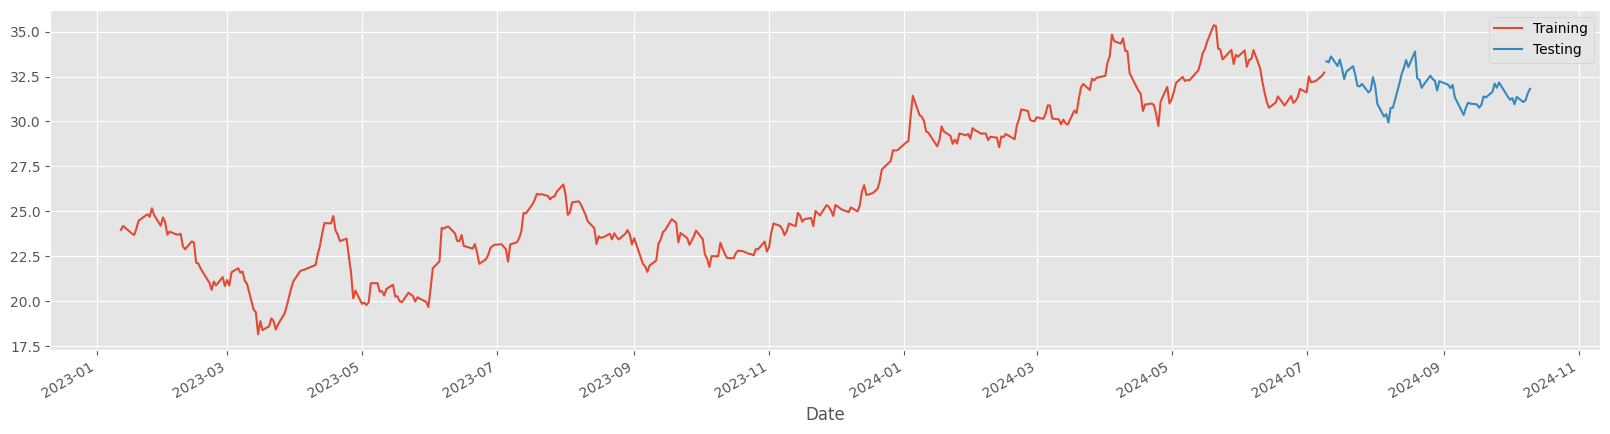

In [78]:
figure, ax = plt.subplots(figsize=(20, 5))
train_data.plot(ax=ax, label="Training",  y="Adj Close")
test_data.plot(ax=ax, label="Testing",  y="Adj Close")
plt.show()

In [79]:
Y_train, Y_test = train_data['Adj Close'], test_data['Adj Close']
x_train, x_test = train_data.drop('Adj Close', axis=1), test_data.drop('Adj Close', axis=1)

## **Model Tuning**

In [80]:
def evaluate_model(y_test, prediction):
  print(f"MAE: {round(mean_absolute_error(y_test, prediction),4)}")
  print(f"MSE: {round(mean_squared_error(y_test, prediction),4)}")
  print(f"MAPE: {round((mean_absolute_percentage_error(y_test, prediction))*100,4)}%")

def plot_predictions(testing_dates, y_test, prediction):
  df_test = pd.DataFrame({"date": testing_dates, "Real": y_test, "prediction": prediction })
  figure, ax = plt.subplots(figsize=(10, 5))
  df_test.plot(ax=ax, label="Real", x="date", y="Real")
  df_test.plot(ax=ax, label="Prediction", x="date", y="prediction")
  plt.legend(["Real", "Prediction"])
  plt.show()

### **Random Forest**

In [81]:
modelRF = RandomForestRegressor(n_estimators=100, random_state=42)
modelRF.fit(x_train, Y_train)

RandomForestRegressor(random_state=42)

In [82]:
#Forecast Test Data
y_pred = modelRF.predict(x_test)

In [83]:
evaluate_model(Y_test,y_pred)

MAE: 0.4467
MSE: 0.3323
MAPE: 1.3958%


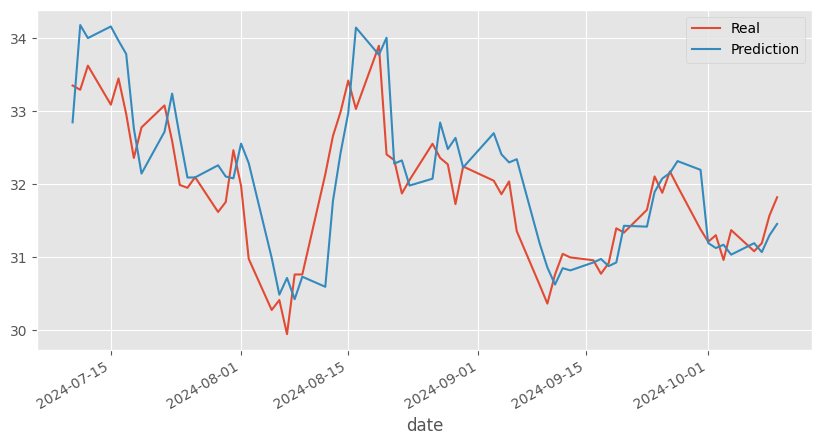

In [84]:
plot_predictions(test_data.index, Y_test, y_pred)

### **XGBoost**

In [85]:
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],

    'max_depth': [3, 5, 7],

    'subsample': [0.8, 0.9, 1.0]
}
grid_search = GridSearchCV(XGBRegressor(), param_grid, cv=3)
grid_search.fit(x_train, Y_train)
best_params = grid_search.best_params_

In [86]:
xgb_model = XGBRegressor(**best_params)
xgb_model.fit(x_train, Y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [87]:
#Forecast Test Data
y_pred_xgb = xgb_model.predict(x_test)

In [88]:
evaluate_model(Y_test,y_pred_xgb)

MAE: 0.4635
MSE: 0.3589
MAPE: 1.447%


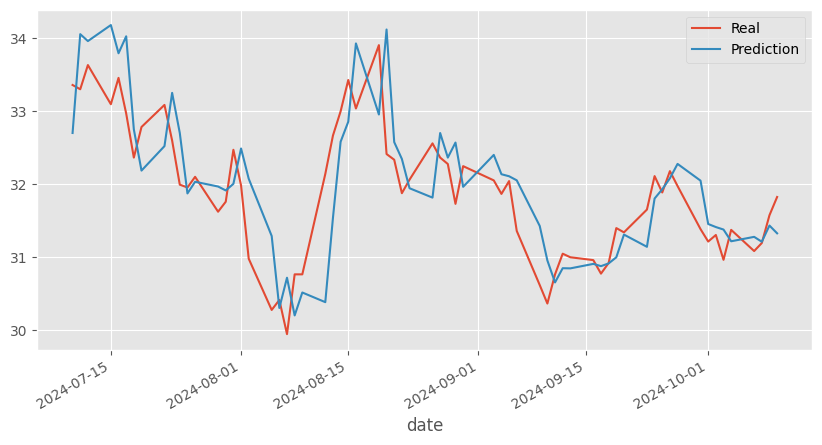

In [89]:
plot_predictions(test_data.index, Y_test, y_pred_xgb)

### **Stacking**

In [92]:
#Define estimators models
estimators = [
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingRegressor(n_estimators=100, random_state=42)),
    ('svr', SVR())
]

In [93]:
#Define meta model
meta_model = LinearRegression()

In [94]:
#Instance and Fit
stacked_model = StackingRegressor(estimators=estimators, final_estimator=meta_model)
stacked_model.fit(x_train, Y_train)

StackingRegressor(estimators=[('rf', RandomForestRegressor(random_state=42)),
                              ('gb',
                               GradientBoostingRegressor(random_state=42)),
                              ('svr', SVR())],
                  final_estimator=LinearRegression())

In [95]:
#Forecast Test Data
y_pred_stacked = stacked_model.predict(x_test)

In [96]:
evaluate_model(Y_test,y_pred_stacked)

MAE: 0.4902
MSE: 0.4605
MAPE: 1.5281%


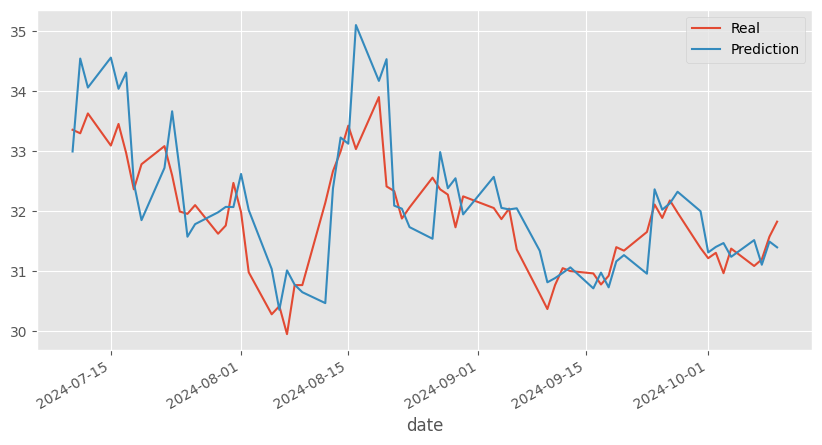

In [97]:
plot_predictions(test_data.index, Y_test, y_pred_stacked)

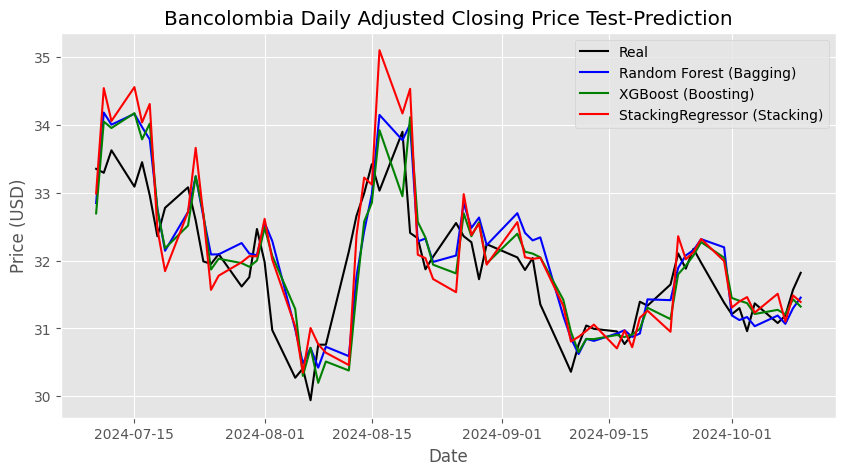

In [99]:
#Graph
plt.figure(figsize=(10, 5))
plt.plot(Y_test.index, Y_test, label='Real',color='Black')
plt.plot(Y_test.index, y_pred, label='Random Forest (Bagging)',color='Blue')
plt.plot(Y_test.index, y_pred_xgb, label='XGBoost (Boosting)',color='Green')
plt.plot(Y_test.index, y_pred_stacked, label='StackingRegressor (Stacking)',color='Red')
plt.title('Bancolombia Daily Adjusted Closing Price Test-Prediction')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
Y_test.dtype


dtype('float64')